<a href="https://colab.research.google.com/github/skillingshark/SummarizeAI/blob/main/SummarizeAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
%%capture
!apt-get update
!pip install fpdf
!pip install tqdm
!pip install PyPDF2
!pip install selenium
!pip install langchain
!pip install pdfminer.six
!pip install transformers
!apt-get install chromium chromium-driver

# Importing required modules

In [ ]:
# Importing required modules

import io
import re
import time
import pprint
import PyPDF2
import resource
import textwrap
from fpdf import FPDF
from tqdm import tqdm
from selenium import webdriver
from google.colab import files
from transformers import pipeline
from transformers import GPT2Tokenizer
from transformers import GPT2TokenizerFast
from selenium.webdriver.common.by import By
from pdfminer.high_level import extract_text
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from langchain.text_splitter import RecursiveCharacterTextSplitter

def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

# Helper functions and models

In [ ]:
# Helper functions and models


%%capture
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

text_splitter = RecursiveCharacterTextSplitter(
    separators = ['\n\n' , '\n' , ' '],
    chunk_size = 1000,
    chunk_overlap  = 25,
)

def model_summary(chunks, model, summ_length):
    print("Summarizing the text. Please wait .......")
    all_summaries = []
    count = 0
    summarizer = pipeline("summarization", model=model)
    print(f'The number of chunks are : {len(chunks)}')
    for chunk in tqdm(chunks):
      tokens = tokenizer.tokenize(str(chunk))
      chunk_size = len(tokens)
      res = summarizer(str(chunk), max_length=chunk_size//summ_length, min_length=chunk_size//summ_length, do_sample=False)
      all_summaries +=res
      count +=1

    return all_summaries

def find_summary_from_raw(raw_text, model, summ_length):

    chunks = text_splitter.create_documents([raw_text])
    all_summaries = model_summary(chunks, model, summ_length) # passing the chunks to the model for the summarization

    joined_summary = ' '.join([summ['summary_text'] for summ in all_summaries])  # combine all chunks of summaries to

    txt_to_save = (joined_summary.encode('latin1','ignore')).decode("latin1")  # This ignores the "aphostrope" which is little problematic
    return txt_to_save

def find_raw_text(mode, url = None):
    if mode == "0":
      uploaded = files.upload()
      raw_text = ""
      for filename, content in uploaded.items():
          stream = io.BytesIO(content)
          raw_text += extract_text(stream)

      return raw_text
    else:
      driver = web_driver()
      driver.get(url)
      raw_text = driver.find_element(By.CSS_SELECTOR, 'body').text
      for i in range(len(raw_text)):
        if raw_text[i].isalnum() == 0 and raw_text[i] != " " and raw_text[i] != "." and raw_text[i] != "," and raw_text[i] != "?" and raw_text[i] != "!" and raw_text[i] != "-":
            if raw_text[i] == '\n':
              raw_text = raw_text.replace(raw_text[i], ".")
            else:
              raw_text = raw_text.replace(raw_text[i], " ")

      return raw_text

def summary(mode, model, summ_length, url=None):
    raw_text = find_raw_text(mode, url)
    txt_to_save = find_summary_from_raw(raw_text, model, summ_length)
    return txt_to_save;

In [ ]:
#@markdown #Summarization

#@markdown - Give mode = "PDF" if you want to upload pdf, for url use mode = "URL"
MODE = "URL" #@param [ "PDF", "URL"]

if MODE == "PDF":
  mode = "0"
else:
  mode = "1"

#@markdown - Give url only if you have selected url mode otherwise leave it empty
URL = "https://www.nbcnews.com/politics/national-security/biden-officials-worry-iran-may-plan-hit-targets-inside-israel-rcna146627" #@param {type:"string"}

#@markdown - Choose model as per requirement

Model_Type = "For URL News/Article Summary" #@param  [ "Basic Model", "For Resume PDF Summary", "For URL News/Article Summary", "For Book/Document PDF Summary (Recommended)"]


if Model_Type == "Basic Model":
  Model_Version = "sshleifer/distilbart-cnn-12-6"
elif Model_Type == "For Resume PDF Summary":
  Model_Version = "Samir001/ResumeSummary-t5-Wang-Arora"
elif Model_Type == "For URL News/Article Summary":
  Model_Version = "mrm8488/t5-base-finetuned-summarize-news"
else:
  Model_Version = "pszemraj/long-t5-tglobal-base-16384-book-summary"

Summary_Length = "Short" #@param ["Long", "Short", "Very Short"]

if Summary_Length == "Long":
  summ_length = 2
elif Summary_Length == "Short":
  summ_length = 3
else:
  summ_length = 5

txt_to_save = summary(mode, Model_Version, summ_length, URL)

Summarizing the text. Please wait .......
The number of chunks are : 6


100%|██████████| 6/6 [00:18<00:00,  3.12s/it]


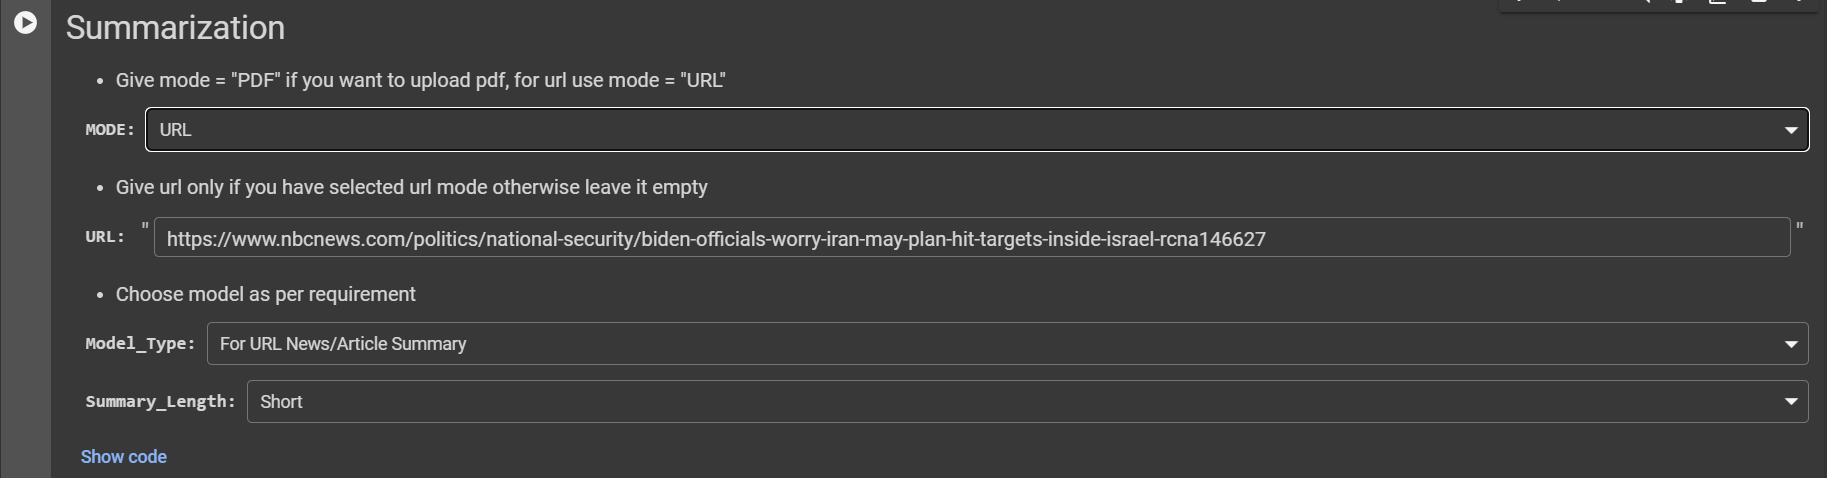

In [ ]:
#@markdown #Sample Output 1

from IPython.display import Markdown
Markdown(f"{txt_to_save}")

Iran has vowed to retaliate for a strike in Damascus that killed several senior Iranian officials, including IRGC Brig. Gen. Mohammad Reza Zahedi. Iran has hit back at the Israeli air strikes in Syria this week, killing a senior Iranian official. The Israeli airstrikes in Syria were a U.S. intelligence assessment warns that Iran could carry out an attack using drones or land-attack cruise missiles in retaliation for the strike in Damascus. Iran is likely to respond before the end of Ramadan next week, officials said. Iran has threatened to re Iran has warned its leaders not to get dragged in Netanyahu's trap for US Stay away so you won't get hurt, Mohammad Jamshidi posted on Facebook. He wrote that in response, the U.S. had asked Iran not to target American facilities. "We made clear that we were not behind the strike Several other people were killed but U.S. officials have not confirmed who they were other than to characterize them as IRGC officials. The picture of Brig. Gen. Mohammad Reza Zahedi, who was killed in an Israeli air strike, was on a billboard in Tehran with a slogan, You will be punished. The U. there haven't been any attacks against U.S. forces in Iraq and Syria for nearly two months. This pause followed an attack by Iranian-backed militants that killed three American service members in Syria that was met with a series of retaliatory strikes from the US. The United States and Israel have been in 'Court. Former Justice Stephen Breyer plans return to the bench as visiting judge for appeals court. 'Trump s 50 million gala set to double Biden s triple-president fundraiser,' said CNN managing editor Carol E. Lee. NBC News

In [ ]:
#################################################################################################################################################33

In [ ]:
#@markdown #Summarization

#@markdown - Give mode = "PDF" if you want to upload pdf, for url use mode = "URL"
MODE = "PDF" #@param [ "PDF", "URL"]

if MODE == "PDF":
  mode = "0"
else:
  mode = "1"

#@markdown - Give url only if you have selected url mode otherwise leave it empty
URL = "" #@param {type:"string"}

#@markdown - Choose model as per requirement

Model_Type = "For Book/Document PDF Summary (Recommended)" #@param  [ "Basic Model", "For Resume PDF Summary", "For URL News/Article Summary", "For Book/Document PDF Summary (Recommended)"]


if Model_Type == "Basic Model":
  Model_Version = "sshleifer/distilbart-cnn-12-6"
elif Model_Type == "For Resume PDF Summary":
  Model_Version = "Samir001/ResumeSummary-t5-Wang-Arora"
elif Model_Type == "For URL News/Article Summary":
  Model_Version = "mrm8488/t5-base-finetuned-summarize-news"
else:
  Model_Version = "pszemraj/long-t5-tglobal-base-16384-book-summary"

Summary_Length = "Short" #@param ["Long", "Short", "Very Short"]

if Summary_Length == "Long":
  summ_length = 2
elif Summary_Length == "Short":
  summ_length = 3
else:
  summ_length = 5

txt_to_save = summary(mode, Model_Version, summ_length, URL)

Saving Tutorial6_questions.pdf to Tutorial6_questions (2).pdf
Summarizing the text. Please wait .......
The number of chunks are : 8


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:916: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 8/8 [00:23<00:00,  2.96s/it]


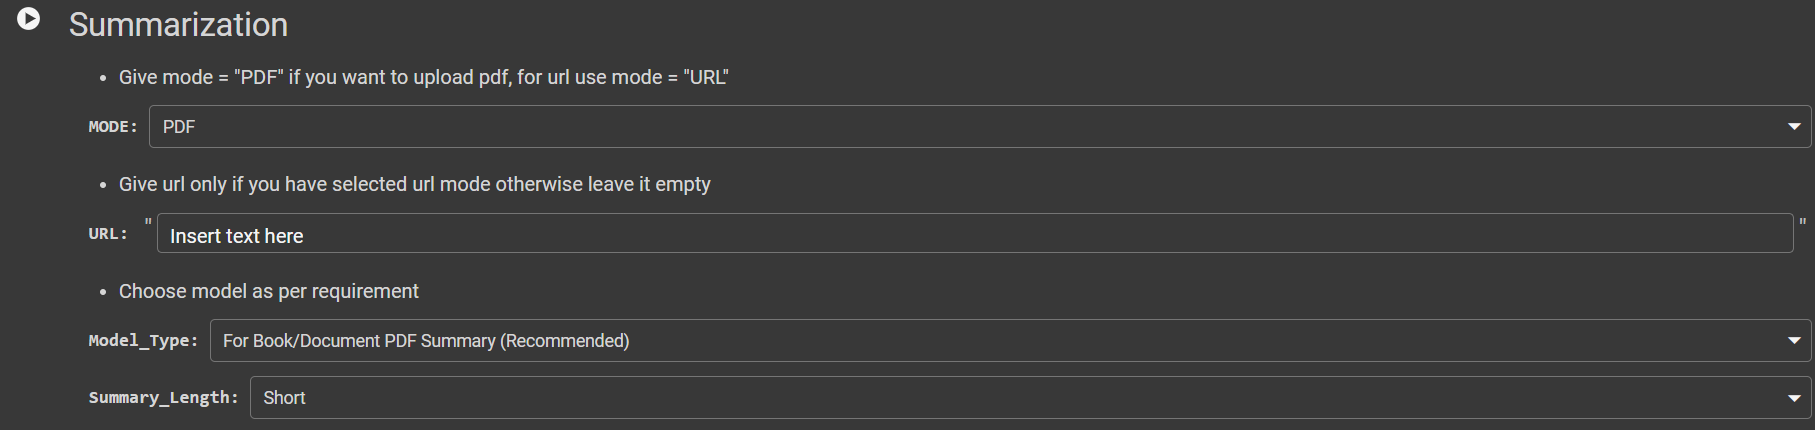

In [ ]:
#@markdown #Sample Output 2

from IPython.display import Markdown
Markdown(f"{txt_to_save}")

In this chapter, the teacher explains some of the problems that will be presented in the following sections. The first problem is to determine if the languages that are being presented are "context-free" or not. This means that they do not have to be read aloud or played with in order to be understood. The second problem concerns the use of the Pumping lemma to determine whether the languages are "constitute-free." If the languages prove This chapter discusses the use of push-down automata in describing how languages can be separated from one another. It uses examples from Context-free languages to illustrate how this In this chapter, we show how a set of states can be represented by a fib-like representation of an input symbol. This is used to describe the behavior of a PDA or a DPDA. For example, if you're trying to represent a sequence of symbols in a stack, you have to use a power set because it represents the entire sequence. If you've got a string with multiple values, you don't need to use an empty stack since all the values are in one place. We call Acceptance by Final State We investigate acceptance Takeaway: A language with a balanced set of prefixes is generally considered to be more complete than its neighbors. In other words, it has the same structure as any other language. For example, a language with only one prefix can be expected to have equal amounts of opening and close parenthesis. This means that even though some languages have multiple prefixesses, they are still not necessarily identical in their structure. The following example illustrates this by showing how an unary alphabet can be used In this chapter, we're introduced to the concept of a deterministic DPDA and how it can be used to represent an expression that has multiple terms. It's important to note that these terms are not always exactly the same thing as the terms in question. For example, when we say "Distance Proposal," we mean "An expression must be two terms and one term should be a result of at least two terms." This means that every expression needs to This paper proves that a dpa can't be written in the language of "balanced parentheses" because it accepts only the first two parenthesis, which are equal to the number of parentheses in the second prefix. The proof is even more The naivete of this statement is that a string can be said to be "minimally balanced" if all its parenthesis are exactly equal to the number of open parentheses in the same string. For example, if we have a constant length of k,

In [ ]:
#################################################################################################################################################

In [ ]:
#@markdown #Summarization

#@markdown - Give mode = "PDF" if you want to upload pdf, for url use mode = "URL"
MODE = "PDF" #@param [ "PDF", "URL"]

if MODE == "PDF":
  mode = "0"
else:
  mode = "1"

#@markdown - Give url only if you have selected url mode otherwise leave it empty
URL = "" #@param {type:"string"}

#@markdown - Choose model as per requirement

Model_Type = "For Resume PDF Summary" #@param  [ "Basic Model", "For Resume PDF Summary", "For URL News/Article Summary", "For Book/Document PDF Summary (Recommended)"]


if Model_Type == "Basic Model":
  Model_Version = "sshleifer/distilbart-cnn-12-6"
elif Model_Type == "For Resume PDF Summary":
  Model_Version = "Samir001/ResumeSummary-t5-Wang-Arora"
elif Model_Type == "For URL News/Article Summary":
  Model_Version = "mrm8488/t5-base-finetuned-summarize-news"
else:
  Model_Version = "pszemraj/long-t5-tglobal-base-16384-book-summary"

Summary_Length = "Short" #@param ["Long", "Short", "Very Short"]

if Summary_Length == "Long":
  summ_length = 2
elif Summary_Length == "Short":
  summ_length = 3
else:
  summ_length = 5

txt_to_save = summary(mode, Model_Version, summ_length, URL)

Saving latest_2_page_resume_new.pdf to latest_2_page_resume_new.pdf
Summarizing the text. Please wait .......


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

The number of chunks are : 12


100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


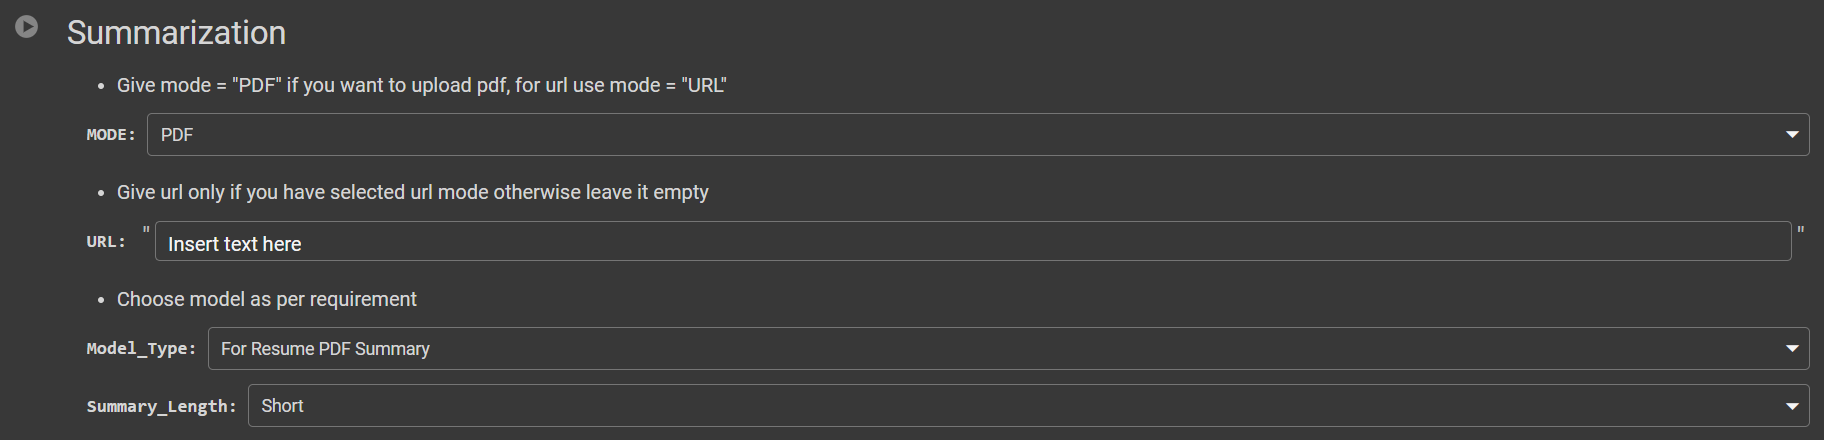

In [ ]:
#@markdown #Sample Output 3

from IPython.display import Markdown
Markdown(f"{txt_to_save}")

The individual possesses a Bachelor of Computer Science and Engineering from Indian Institute of Technology, Bombay. They have completed their studies at B.Tech., with a bachelor's degree in Computer Science or Engineering from India Institute Of Technology. They are currently working as a Computer Science Technician at Bangalore. They hold a Master's Degree in Computing from IIT Bombanay, and have achieved All India rank 220 in the JEE Main exam. They also secured All IndiaRank 533 among 900,0000+ candidates in Jaju The author describes how the University has achieved All India rank 17 in national mathematics talent contest, selected for Indian National junior science Olympiad, and released from HBCSE as a result of conducting Indian National JuniorScience Olympiad. He also secured top grades in various subjects, including Physics, Chemistry, and Astronomy. Furthermore, he has implemented Auto The individual demonstrates how they have implemented DCGAN modeling, conditional gandin model, and stable diffusion model. They have also used Gradio's Stable Difffusion model to create designs that match the designs provided by the model. Additionally, they have developed a Python program for training generalize deep learning tasks like classification, segmentation, and The individual possesses skills in command-line arguments parsing, machine learning modeling, and industrial applications of data science. They have completed a course at IIT Bombanay, where they developed a machine learning model using Linear regression to predict vibratory critical equipment in chemical processing plants, performed exploratory analysis and denoised datavia bounding The individual demonstrates an understanding of web crawler technology and uses BeautifulSoup to explore internal and external links. They also develop an additional classification mechanism for linking using link extension and hierarchically-aligned levels. Their final product is The individual demonstrates an understanding of algorithmic trading, using C++ and arbitrage detection. They have implemented a stock trade strategy with C code, implemented an arbitrage detector algorithm, and extended the algorithm to Optimize Collective Order Execution for complex linear combination. They also designed and created an eCommerce website for Vibli The individual demonstrates proficiency in the JavaScript language and implements various features of the application Algotrading is a summer of science 2023 focused on learning how to implement algorithms and quantitative analysis in Python. The student also has experience in financial data analysis, backtesting, performance evaluations, and trading algorithms. They have also learned how to Automate trade decisions for currencies or stocks with Interactive Brokers using APIs, The author explains how the code was developed and how it was used in Bombay. He also describes how he implemented a The narrator describes the various branches of the programming language used in Bombay. He also lists the roles and responsibilities of each individual involved in the project. For example, he is involved in projects such as technical summer school, code creation, blockchain workshops, and computational science. Other assignments include hosting a technical summer college, conducting a course on data structures and algorithms, conducting The individual possesses skills in data structures, algorithms, discrete structures, data analysis and interpretation, Software Systems Lab, programming for data science, design and analysis of algorithmes, numérique systems lab, Programming For Data Science, DESIGN AND ANALYSIS OF ALGORITMS,DATA DESIGN AND CARIMETMS, ABSTRACIMENTS AND PARIMPOM The individual has completed a year of NCC training and participates in a 5 mile marathon. They have also worked as a team member in an analysis of OX'

In [ ]:
#################################################################################################################################################

In [ ]:
#@markdown #Summarization

#@markdown - Give mode = "PDF" if you want to upload pdf, for url use mode = "URL"
MODE = "PDF" #@param [ "PDF", "URL"]

if MODE == "PDF":
  mode = "0"
else:
  mode = "1"

#@markdown - Give url only if you have selected url mode otherwise leave it empty
URL = "" #@param {type:"string"}

#@markdown - Choose model as per requirement

Model_Type = "For Resume PDF Summary" #@param  [ "Basic Model", "For Resume PDF Summary", "For URL News/Article Summary", "For Book/Document PDF Summary (Recommended)"]


if Model_Type == "Basic Model":
  Model_Version = "sshleifer/distilbart-cnn-12-6"
elif Model_Type == "For Resume PDF Summary":
  Model_Version = "Samir001/ResumeSummary-t5-Wang-Arora"
elif Model_Type == "For URL News/Article Summary":
  Model_Version = "mrm8488/t5-base-finetuned-summarize-news"
else:
  Model_Version = "pszemraj/long-t5-tglobal-base-16384-book-summary"

Summary_Length = "Short" #@param ["Long", "Short", "Very Short"]

if Summary_Length == "Long":
  summ_length = 2
elif Summary_Length == "Short":
  summ_length = 3
else:
  summ_length = 5

txt_to_save = summary(mode, Model_Version, summ_length, URL)

Saving DivyanshuSuman_Resume_2pg.pdf to DivyanshuSuman_Resume_2pg.pdf
Summarizing the text. Please wait .......
The number of chunks are : 11


100%|██████████| 11/11 [00:25<00:00,  2.35s/it]


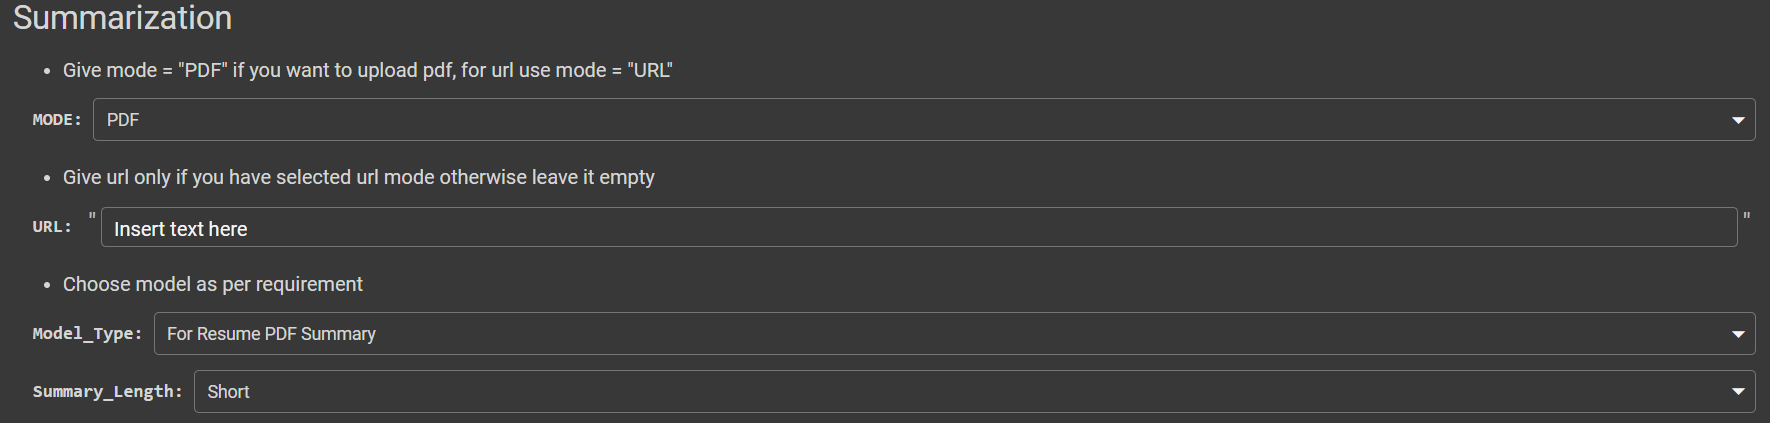

In [ ]:
#@markdown #Sample Output 4

from IPython.display import Markdown
Markdown(f"{txt_to_save}")

The individual holds a Bachelor's degree in Engineering from Indian Institute of Technology, Bombay. They have completed their studies at B.Tech. and have graduated from university. They currently pursue a minor in artificial intelligence and data science. They are currently pursuing an advanced minor in Artificial Intellicence and Data Sciences. They hold a Department rank 10 in Chemical Engineering and secured 99.14percentile out of 1.23 million candidates who appear for the JEE Advanced or JEE Main respectively. The individual explains how they have developed a Python packages for training generalized deep learning tasks like classification, segmentation, and fastAPI. They have also leveraged Python libraries such as Argparse to provide custom-tailred machine learning The individual demonstrates expertise in various web and coding tools, including CompVis Rspository, FastAPI, and Google Colab. They have developed an API for stable diffusion modeling, developed an endpoint for it, and employed the Colab Code Python module for development and deployment. Additionally, they have implemented the Skipgram Word Embedment Model on a specific document corp The individual explains how they used the extended problem of analysing real life scenarios such as targeted advertising, customer differentiation, and stayingzien hotels to analyze real life scenario like targeted advertising. They also worked on creating a hotel The individual focuses on exploring algorithmic trading techniques using Python, quantitative analysis, and financial data. They have also learned how to analyze financial data for patterns, and conduct comprehensive This chapter describes the process of creating a web crawler and using BeautifulSoup to collect data from web pages. It also describes how the crawler enables the organization of links and provides an additional classification feature for linking. Additionally, it implements The individual has worked on several projects, including a sign language recognitioner, a routing robot, and an autonomous line-follower robot. They have also completed a mentorship program in the Institute of Technology Bombay, where they have developed an autonomous machine capable of transporting cargo and scaling slopes while using Arduino code and IR sensors to track input and motor driver board The individual possesses extensive experience in the fields of programming and game development. They have worked on projects such as Nokia Snake Game, a game for iOS devices, and a technical summer school. They also have mentored over 900 students in their courses on data structures and algorithmics. Additionally, they have organized various sessions like Introductory Programming, Blockchain, and Workshop. The individual contributes various projects to the new season of code, such as development of a web portal, implementation of stablediffusion model, and creating an API endpoint. They are also responsible for managing the Entrepreneurship cell in India, which manages The individual possesses skills in Computer Programming and Utilisation, Programmer Programming for data science, statistical mathematics, machine learning and data mining, artificial intelligence and data science. They also have experience in chemical engineering, material and energy balances, transport, process fluid mechanics, chemical engineering thermodynasty, Process FluidMechics, linear Algebra/differential The individual possesses skills in machine learning, regression, classification, clustering, natural language processing, and Python. They have worked as a volunteer at the Educational Outreach program at IIT Bombanay, where they gained 4th place in SARCAsmcrypthunt among 100+ students, secured position in codewarsv2, and participated in programming contests such as CodeForce and CodeChef.

In [ ]:
########################################################################################################################################

In [ ]:
#@markdown #Summarization

#@markdown - Give mode = "PDF" if you want to upload pdf, for url use mode = "URL"
MODE = "URL" #@param [ "PDF", "URL"]

if MODE == "PDF":
  mode = "0"
else:
  mode = "1"

#@markdown - Give url only if you have selected url mode otherwise leave it empty
URL = "https://www.vedantu.com/english/ms-dhoni-essay" #@param {type:"string"}

#@markdown - Choose model as per requirement

Model_Type = "For URL News/Article Summary" #@param  [ "Basic Model", "For Resume PDF Summary", "For URL News/Article Summary", "For Book/Document PDF Summary (Recommended)"]


if Model_Type == "Basic Model":
  Model_Version = "sshleifer/distilbart-cnn-12-6"
elif Model_Type == "For Resume PDF Summary":
  Model_Version = "Samir001/ResumeSummary-t5-Wang-Arora"
elif Model_Type == "For URL News/Article Summary":
  Model_Version = "mrm8488/t5-base-finetuned-summarize-news"
else:
  Model_Version = "pszemraj/long-t5-tglobal-base-16384-book-summary"

Summary_Length = "Short" #@param ["Long", "Short", "Very Short"]

if Summary_Length == "Long":
  summ_length = 2
elif Summary_Length == "Short":
  summ_length = 3
else:
  summ_length = 5

txt_to_save = summary(mode, Model_Version, summ_length, URL)

Summarizing the text. Please wait .......
The number of chunks are : 15


100%|██████████| 15/15 [00:47<00:00,  3.20s/it]


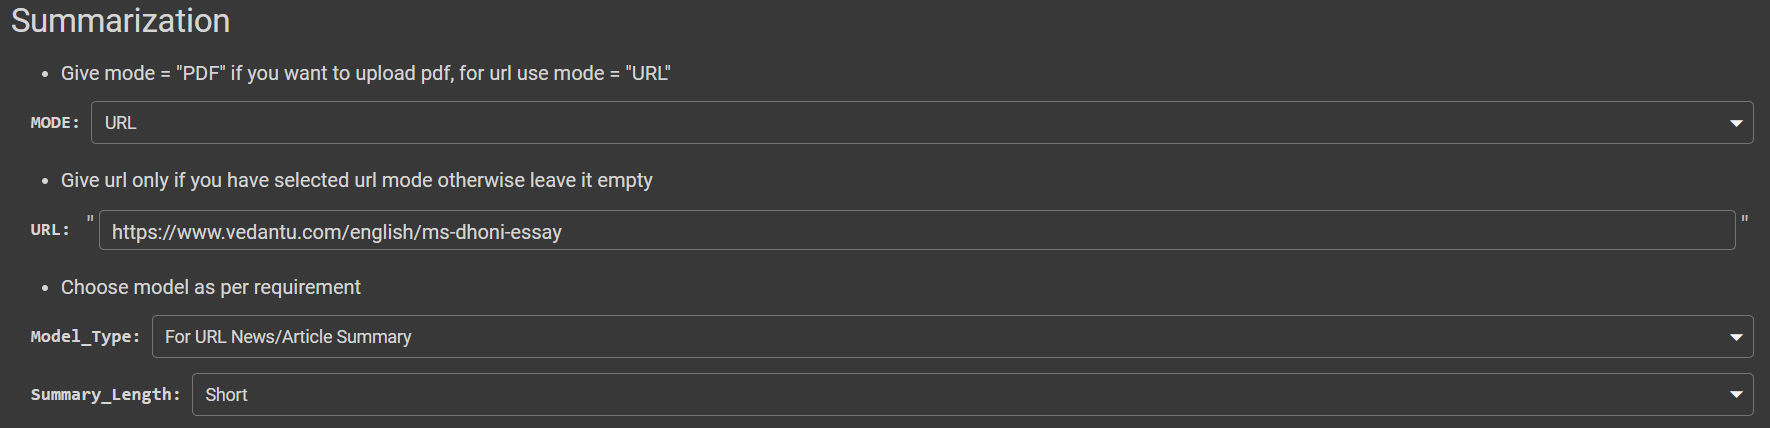

In [ ]:
#@markdown #Sample Output 5

from IPython.display import Markdown
Markdown(f"{txt_to_save}")

MS Dhoni is one of the coolest captains in the world and a popular sport in India. People go insane when any national or international cricket event is organized in India or telecasted. The students will be able to write a short essay on him after following the points mentioned in this article. 'Cricket is a religion in India, and people go insane Mahendra Singh Dhoni was born in 1981 in Ranchi, Jharkhand. His parents are Pan Singh and Devaki Dev and his father was a junior manager in Mecon. "He was an excellent goalkeeper. Watching his eye-catchy skills, his football coach sent him to a local cricket club to play cricket 'As' was selected as the U-19 Bihar cricket squad member in 1998-99. When he was 18 years old, he scored a half-century in the Ranji Trophy match for Bihar. His excellent performance and a century for the East Zone helped the team to clinch the Deodhar Trophy Test captain PC Poddar became the clinical destroyer of commendable bowling attacks in the 60s. He hit 10 6s, the highest an Indian has hit in a Test inning. He eventually became the captain of the Indian international team and clinched the World Cup in 2011. PC was christened with the new name Mahendra Singh Dhoni became one of the best captains in Indian cricket history after winning the LG 'People's Choice Award' in 2013. He was awarded the Rajiv Gandhi Khel Ratna, the highest honour for a sportsperson. Known for his outstanding performances in all types of cricket, MS was a Mahendra Singh Dhoni is considered to be one of the greatest cricket captains of all time in the world. He won the Rajiv Gandhi Khel Ratna award in 2007-08. He also received LG s People's Choice Award in 2013. "Under his formidable captaincy, the attitude of the entire cricket team in India cricket is played from the British rule period. The game was introduced in India by the Britishers. MS Dhoni is one of the most respected cricketers in the country. He is known for his captaincy and playing strategy. Notably, his father was a hard-working man who wanted his son to join government services.nn 'DAV Jawahar Vidya Mandir School', located in Ranchi, India, has trained goalkeepers since he was eight years old. He joined Indian Railways as a TTE train ticket examiner after his father convinced him that he wanted to create his career in cricket. 'Bihar' Ambedkar Jayanti is known for his captaincy all over the world and has huge respect. He showed that a common boy with hard work can achieve his dream. He had a remarkable journey in his cricket career that everyone should know and learn from it. Animals Sound in English for Kids.Body Parts Name and Functions For Kids.Example MS Dhoni's family includes Pan Singh, his mother Devaki Dev, and his elder sister. Describe the family and surroundings of the boy, who used to live in Ranchi, Jharkhand. The boy's father always wanted him to join any government services, but he always had an interest in sports. He used to play in his schools football team and after his NCERT Solutions for Class 12 Maths, Physics, Chemistry, Business Studies, Accountancy, English, Hindi, and NCERT's Hindi versions of the Test are available for download as well as English versions. The Test is being conducted by the National Cricket Academy for the first time in its history. Notably, Dhoni is the only Indian cricketer to be NCERT Solutions for Class 10 Hindi. NCERT Solution for Class 9 Social Science.NCERT Solutions For Class 8.NCERT Books.nCERT Books Class 12.NCERT Book Class 11. NCERT Books class 10.NCERT books class 9. NCERT Book Solutions.Reference book solutions.HC Verma Solutions.RD Sharma Solutions.RS Aggarwal Solutions.Lakhmir Singh Solutions.DK Goel Solutions.TS Free Study Material.Previous Year Question Papers.CBSE Sample Papers, CBSE Worksheets, and CBI Exams. Free study material. Free Study Materials.CbSE Preliminary Results.Citizens Learning.Ask Questions.Important Subjects.Physics.Biology.Chemistry.Maths.English.Commerce.Ge JEE Advanced Difference between.JEE Advanced Syllabus.NEET Physics Syllabi,NEET Chemistry Syllafliabus and NEET Previous Year Question Paper. Offline CENTRES.Muzaffarpur.Chennai.Bangalore.Patiala.Delhi.Vijayawada.Visakhapatnam.Tiruchirapalli.Madurai.Coimbatore. page_content=